In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

from lime import lime_image
from skimage.segmentation import mark_boundaries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image

import os

/home/bendico765/Scrivania/Gianluca/Università/CHL-Project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_input_tensors(img): 
    """
    Applies the transformation to the image (resize, center crop, normalize) and returns its tensor version
    
    @param img: a PIL image
    @return a tensor image
    """
    transf = transforms.Compose([
            transforms.Resize(400),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transf(img).unsqueeze(0)

def get_image(path):
    """
    Loads the specified image
    
    @param path: path to the image
    @return a PIL image
    """
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 

# Example of prediction for a single image

In [3]:
# load the torch model
model = torch.load("model.pt", map_location=torch.device('cpu'))
model.eval() # set the model to eval mode

# load the labels of the images
labels_df = pd.read_csv("./data/overall_labels.csv")
labels_df.rename(columns={"Unnamed: 0": "filename"}, inplace=True)

In [4]:
# pick image
img_o = labels_df.iloc[0]

# load image
img = get_image(f'./data/original/{img_o.filename}')

# compute the labels
real_label = "AKU" if img_o.AKU > img_o.HEALTHY else "HEALTHY" # take the real label

# compute the predicted label
img_t = get_input_tensors(img)
logits = model(img_t) 
predicted_label= "AKU" if logits.argmax(dim=1).item() == 1 else "HEALTHY"

/home/bendico765/Scrivania/Gianluca/Università/CHL-Project/venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [5]:
def batch_predict(images):
    """
    Function that, given a batch of images, outputs prediction probabilities

    @param iterable containing images for the classifier
    @return array of prediction probabilities
    """
    model.eval()
    transf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   
    ])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # stack the images and send them to the selected device
    batch = torch.stack(tuple(transf(i) for i in images), dim=0)
    batch = batch.to(device)

    # compute the prediction probabilities
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

# trasformations applied to uniform the images (making them suitable for the model)
pill_transf = transforms.Compose([ transforms.Resize(400) ])

explainer = lime_image.LimeImageExplainer()
# generate explanations for a prediction
explanation = explainer.explain_instance(np.array(pill_transf(img)), # this parameter needs image casted to numpy array
                                         batch_predict, # classification function
                                         top_labels=2, # produce explanation for top 2 labels
                                         hide_color=0, 
                                         num_samples=10) # number of images that will be sent to the classification

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.11it/s]


<Figure size 640x480 with 0 Axes>

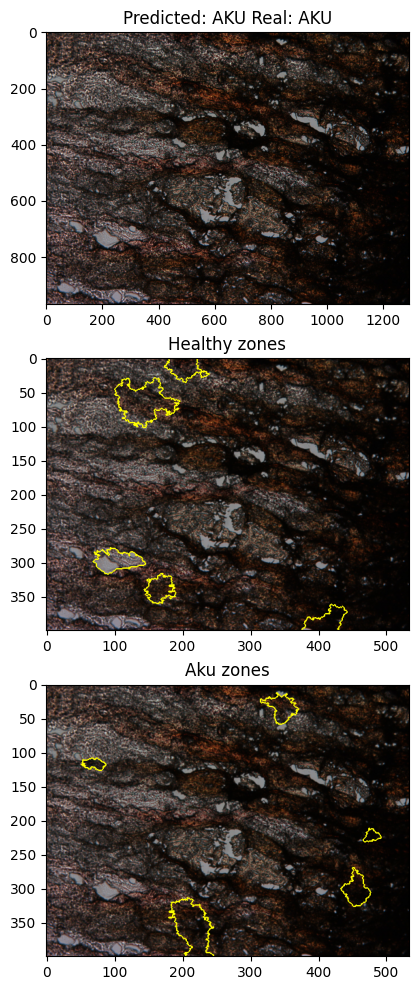

In [7]:
# get mask for healthy
temp, mask = explanation.get_image_and_mask(
    0, #label to explain
    positive_only=True, # take only super pixels that contributed to the prediction of the label
    num_features=5, # how many super pixels include in the explanation
    hide_rest=False
)
# apply mask on the original image
healthy_zones = mark_boundaries(temp/255.0, mask, mode="thick")

# get mask for aku
temp, mask = explanation.get_image_and_mask(
    1, 
    positive_only=True, 
    num_features=5, 
    hide_rest=False
)
# apply mask on the original image
aku_boundaries = mark_boundaries(temp/255.0, mask, mode="thick")

plt.figure()
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(12,12)) 
ax1.set_title(f"Predicted: {real_label} Real: {predicted_label}")
ax1.imshow(img)
ax2.set_title("Healthy zones")
ax2.imshow(healthy_zones)
ax3.set_title("Aku zones")
ax3.imshow(aku_boundaries)